In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json
import os
import pdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# ML Analysis of simulated outbreaks

This uses a RNN on the sequence of confimed clinical cases

## Read the data in

In [73]:
def load_files(path):

    flist = os.listdir(path)

    Cc = dict()
    Params = dict()

    for i, f in enumerate(flist):
        print("Loading", i, "of", len(flist))
        if "_Cc.json" in f:
            with open(os.path.join(path,f) ) as fp:
                Cc[f.replace("_Cc.json", "")] = json.load(fp)
            continue
        elif "_params.json" in f:
            with open(os.path.join(path,f) ) as fp:
                Params[f.replace("_params.json", "")] = json.load(fp)
            continue
        else:
            raise ValueError("File names must have either _Cc.json or _params.json")

    if not all([f in Params.keys() for f in Cc.keys()]):
        raise ValueError("Not all params and curves present")

    Cc_v = list()
    Params_v = list()
    for i in Cc.keys():
        Cc_v.append(Cc[i])
        Params_v.append(Params[i])

    return Params_v, Cc_v

Load the data and reshape

In [213]:
Params, Cc = load_files("sims/23_06_20")

# Pad the Cc vector with zeros so they are all the same length
max_vsize = max([len(x) for x in Cc])
[x.extend([0]*(max_vsize - len(x))) for x in Cc]
X = np.array(Cc)

## Pull the labels
y = pd.DataFrame(Params)[['BETA1', 'cm']]

Loading 0 of 8008
Loading 1 of 8008
Loading 2 of 8008
Loading 3 of 8008
Loading 4 of 8008
Loading 5 of 8008
Loading 6 of 8008
Loading 7 of 8008
Loading 8 of 8008
Loading 9 of 8008
Loading 10 of 8008
Loading 11 of 8008
Loading 12 of 8008
Loading 13 of 8008
Loading 14 of 8008
Loading 15 of 8008
Loading 16 of 8008
Loading 17 of 8008
Loading 18 of 8008
Loading 19 of 8008
Loading 20 of 8008
Loading 21 of 8008
Loading 22 of 8008
Loading 23 of 8008
Loading 24 of 8008
Loading 25 of 8008
Loading 26 of 8008
Loading 27 of 8008
Loading 28 of 8008
Loading 29 of 8008
Loading 30 of 8008
Loading 31 of 8008
Loading 32 of 8008
Loading 33 of 8008
Loading 34 of 8008
Loading 35 of 8008
Loading 36 of 8008
Loading 37 of 8008
Loading 38 of 8008
Loading 39 of 8008
Loading 40 of 8008
Loading 41 of 8008
Loading 42 of 8008
Loading 43 of 8008
Loading 44 of 8008
Loading 45 of 8008
Loading 46 of 8008
Loading 47 of 8008
Loading 48 of 8008
Loading 49 of 8008
Loading 50 of 8008
Loading 51 of 8008
Loading 52 of 8008
Loa

Loading 640 of 8008
Loading 641 of 8008
Loading 642 of 8008
Loading 643 of 8008
Loading 644 of 8008
Loading 645 of 8008
Loading 646 of 8008
Loading 647 of 8008
Loading 648 of 8008
Loading 649 of 8008
Loading 650 of 8008
Loading 651 of 8008
Loading 652 of 8008
Loading 653 of 8008
Loading 654 of 8008
Loading 655 of 8008
Loading 656 of 8008
Loading 657 of 8008
Loading 658 of 8008
Loading 659 of 8008
Loading 660 of 8008
Loading 661 of 8008
Loading 662 of 8008
Loading 663 of 8008
Loading 664 of 8008
Loading 665 of 8008
Loading 666 of 8008
Loading 667 of 8008
Loading 668 of 8008
Loading 669 of 8008
Loading 670 of 8008
Loading 671 of 8008
Loading 672 of 8008
Loading 673 of 8008
Loading 674 of 8008
Loading 675 of 8008
Loading 676 of 8008
Loading 677 of 8008
Loading 678 of 8008
Loading 679 of 8008
Loading 680 of 8008
Loading 681 of 8008
Loading 682 of 8008
Loading 683 of 8008
Loading 684 of 8008
Loading 685 of 8008
Loading 686 of 8008
Loading 687 of 8008
Loading 688 of 8008
Loading 689 of 8008


Loading 1383 of 8008
Loading 1384 of 8008
Loading 1385 of 8008
Loading 1386 of 8008
Loading 1387 of 8008
Loading 1388 of 8008
Loading 1389 of 8008
Loading 1390 of 8008
Loading 1391 of 8008
Loading 1392 of 8008
Loading 1393 of 8008
Loading 1394 of 8008
Loading 1395 of 8008
Loading 1396 of 8008
Loading 1397 of 8008
Loading 1398 of 8008
Loading 1399 of 8008
Loading 1400 of 8008
Loading 1401 of 8008
Loading 1402 of 8008
Loading 1403 of 8008
Loading 1404 of 8008
Loading 1405 of 8008
Loading 1406 of 8008
Loading 1407 of 8008
Loading 1408 of 8008
Loading 1409 of 8008
Loading 1410 of 8008
Loading 1411 of 8008
Loading 1412 of 8008
Loading 1413 of 8008
Loading 1414 of 8008
Loading 1415 of 8008
Loading 1416 of 8008
Loading 1417 of 8008
Loading 1418 of 8008
Loading 1419 of 8008
Loading 1420 of 8008
Loading 1421 of 8008
Loading 1422 of 8008
Loading 1423 of 8008
Loading 1424 of 8008
Loading 1425 of 8008
Loading 1426 of 8008
Loading 1427 of 8008
Loading 1428 of 8008
Loading 1429 of 8008
Loading 1430 

Loading 2186 of 8008
Loading 2187 of 8008
Loading 2188 of 8008
Loading 2189 of 8008
Loading 2190 of 8008
Loading 2191 of 8008
Loading 2192 of 8008
Loading 2193 of 8008
Loading 2194 of 8008
Loading 2195 of 8008
Loading 2196 of 8008
Loading 2197 of 8008
Loading 2198 of 8008
Loading 2199 of 8008
Loading 2200 of 8008
Loading 2201 of 8008
Loading 2202 of 8008
Loading 2203 of 8008
Loading 2204 of 8008
Loading 2205 of 8008
Loading 2206 of 8008
Loading 2207 of 8008
Loading 2208 of 8008
Loading 2209 of 8008
Loading 2210 of 8008
Loading 2211 of 8008
Loading 2212 of 8008
Loading 2213 of 8008
Loading 2214 of 8008
Loading 2215 of 8008
Loading 2216 of 8008
Loading 2217 of 8008
Loading 2218 of 8008
Loading 2219 of 8008
Loading 2220 of 8008
Loading 2221 of 8008
Loading 2222 of 8008
Loading 2223 of 8008
Loading 2224 of 8008
Loading 2225 of 8008
Loading 2226 of 8008
Loading 2227 of 8008
Loading 2228 of 8008
Loading 2229 of 8008
Loading 2230 of 8008
Loading 2231 of 8008
Loading 2232 of 8008
Loading 2233 

Loading 3031 of 8008
Loading 3032 of 8008
Loading 3033 of 8008
Loading 3034 of 8008
Loading 3035 of 8008
Loading 3036 of 8008
Loading 3037 of 8008
Loading 3038 of 8008
Loading 3039 of 8008
Loading 3040 of 8008
Loading 3041 of 8008
Loading 3042 of 8008
Loading 3043 of 8008
Loading 3044 of 8008
Loading 3045 of 8008
Loading 3046 of 8008
Loading 3047 of 8008
Loading 3048 of 8008
Loading 3049 of 8008
Loading 3050 of 8008
Loading 3051 of 8008
Loading 3052 of 8008
Loading 3053 of 8008
Loading 3054 of 8008
Loading 3055 of 8008
Loading 3056 of 8008
Loading 3057 of 8008
Loading 3058 of 8008
Loading 3059 of 8008
Loading 3060 of 8008
Loading 3061 of 8008
Loading 3062 of 8008
Loading 3063 of 8008
Loading 3064 of 8008
Loading 3065 of 8008
Loading 3066 of 8008
Loading 3067 of 8008
Loading 3068 of 8008
Loading 3069 of 8008
Loading 3070 of 8008
Loading 3071 of 8008
Loading 3072 of 8008
Loading 3073 of 8008
Loading 3074 of 8008
Loading 3075 of 8008
Loading 3076 of 8008
Loading 3077 of 8008
Loading 3078 

Loading 3797 of 8008
Loading 3798 of 8008
Loading 3799 of 8008
Loading 3800 of 8008
Loading 3801 of 8008
Loading 3802 of 8008
Loading 3803 of 8008
Loading 3804 of 8008
Loading 3805 of 8008
Loading 3806 of 8008
Loading 3807 of 8008
Loading 3808 of 8008
Loading 3809 of 8008
Loading 3810 of 8008
Loading 3811 of 8008
Loading 3812 of 8008
Loading 3813 of 8008
Loading 3814 of 8008
Loading 3815 of 8008
Loading 3816 of 8008
Loading 3817 of 8008
Loading 3818 of 8008
Loading 3819 of 8008
Loading 3820 of 8008
Loading 3821 of 8008
Loading 3822 of 8008
Loading 3823 of 8008
Loading 3824 of 8008
Loading 3825 of 8008
Loading 3826 of 8008
Loading 3827 of 8008
Loading 3828 of 8008
Loading 3829 of 8008
Loading 3830 of 8008
Loading 3831 of 8008
Loading 3832 of 8008
Loading 3833 of 8008
Loading 3834 of 8008
Loading 3835 of 8008
Loading 3836 of 8008
Loading 3837 of 8008
Loading 3838 of 8008
Loading 3839 of 8008
Loading 3840 of 8008
Loading 3841 of 8008
Loading 3842 of 8008
Loading 3843 of 8008
Loading 3844 

Loading 4628 of 8008
Loading 4629 of 8008
Loading 4630 of 8008
Loading 4631 of 8008
Loading 4632 of 8008
Loading 4633 of 8008
Loading 4634 of 8008
Loading 4635 of 8008
Loading 4636 of 8008
Loading 4637 of 8008
Loading 4638 of 8008
Loading 4639 of 8008
Loading 4640 of 8008
Loading 4641 of 8008
Loading 4642 of 8008
Loading 4643 of 8008
Loading 4644 of 8008
Loading 4645 of 8008
Loading 4646 of 8008
Loading 4647 of 8008
Loading 4648 of 8008
Loading 4649 of 8008
Loading 4650 of 8008
Loading 4651 of 8008
Loading 4652 of 8008
Loading 4653 of 8008
Loading 4654 of 8008
Loading 4655 of 8008
Loading 4656 of 8008
Loading 4657 of 8008
Loading 4658 of 8008
Loading 4659 of 8008
Loading 4660 of 8008
Loading 4661 of 8008
Loading 4662 of 8008
Loading 4663 of 8008
Loading 4664 of 8008
Loading 4665 of 8008
Loading 4666 of 8008
Loading 4667 of 8008
Loading 4668 of 8008
Loading 4669 of 8008
Loading 4670 of 8008
Loading 4671 of 8008
Loading 4672 of 8008
Loading 4673 of 8008
Loading 4674 of 8008
Loading 4675 

Loading 5450 of 8008
Loading 5451 of 8008
Loading 5452 of 8008
Loading 5453 of 8008
Loading 5454 of 8008
Loading 5455 of 8008
Loading 5456 of 8008
Loading 5457 of 8008
Loading 5458 of 8008
Loading 5459 of 8008
Loading 5460 of 8008
Loading 5461 of 8008
Loading 5462 of 8008
Loading 5463 of 8008
Loading 5464 of 8008
Loading 5465 of 8008
Loading 5466 of 8008
Loading 5467 of 8008
Loading 5468 of 8008
Loading 5469 of 8008
Loading 5470 of 8008
Loading 5471 of 8008
Loading 5472 of 8008
Loading 5473 of 8008
Loading 5474 of 8008
Loading 5475 of 8008
Loading 5476 of 8008
Loading 5477 of 8008
Loading 5478 of 8008
Loading 5479 of 8008
Loading 5480 of 8008
Loading 5481 of 8008
Loading 5482 of 8008
Loading 5483 of 8008
Loading 5484 of 8008
Loading 5485 of 8008
Loading 5486 of 8008
Loading 5487 of 8008
Loading 5488 of 8008
Loading 5489 of 8008
Loading 5490 of 8008
Loading 5491 of 8008
Loading 5492 of 8008
Loading 5493 of 8008
Loading 5494 of 8008
Loading 5495 of 8008
Loading 5496 of 8008
Loading 5497 

Loading 6284 of 8008
Loading 6285 of 8008
Loading 6286 of 8008
Loading 6287 of 8008
Loading 6288 of 8008
Loading 6289 of 8008
Loading 6290 of 8008
Loading 6291 of 8008
Loading 6292 of 8008
Loading 6293 of 8008
Loading 6294 of 8008
Loading 6295 of 8008
Loading 6296 of 8008
Loading 6297 of 8008
Loading 6298 of 8008
Loading 6299 of 8008
Loading 6300 of 8008
Loading 6301 of 8008
Loading 6302 of 8008
Loading 6303 of 8008
Loading 6304 of 8008
Loading 6305 of 8008
Loading 6306 of 8008
Loading 6307 of 8008
Loading 6308 of 8008
Loading 6309 of 8008
Loading 6310 of 8008
Loading 6311 of 8008
Loading 6312 of 8008
Loading 6313 of 8008
Loading 6314 of 8008
Loading 6315 of 8008
Loading 6316 of 8008
Loading 6317 of 8008
Loading 6318 of 8008
Loading 6319 of 8008
Loading 6320 of 8008
Loading 6321 of 8008
Loading 6322 of 8008
Loading 6323 of 8008
Loading 6324 of 8008
Loading 6325 of 8008
Loading 6326 of 8008
Loading 6327 of 8008
Loading 6328 of 8008
Loading 6329 of 8008
Loading 6330 of 8008
Loading 6331 

Loading 7095 of 8008
Loading 7096 of 8008
Loading 7097 of 8008
Loading 7098 of 8008
Loading 7099 of 8008
Loading 7100 of 8008
Loading 7101 of 8008
Loading 7102 of 8008
Loading 7103 of 8008
Loading 7104 of 8008
Loading 7105 of 8008
Loading 7106 of 8008
Loading 7107 of 8008
Loading 7108 of 8008
Loading 7109 of 8008
Loading 7110 of 8008
Loading 7111 of 8008
Loading 7112 of 8008
Loading 7113 of 8008
Loading 7114 of 8008
Loading 7115 of 8008
Loading 7116 of 8008
Loading 7117 of 8008
Loading 7118 of 8008
Loading 7119 of 8008
Loading 7120 of 8008
Loading 7121 of 8008
Loading 7122 of 8008
Loading 7123 of 8008
Loading 7124 of 8008
Loading 7125 of 8008
Loading 7126 of 8008
Loading 7127 of 8008
Loading 7128 of 8008
Loading 7129 of 8008
Loading 7130 of 8008
Loading 7131 of 8008
Loading 7132 of 8008
Loading 7133 of 8008
Loading 7134 of 8008
Loading 7135 of 8008
Loading 7136 of 8008
Loading 7137 of 8008
Loading 7138 of 8008
Loading 7139 of 8008
Loading 7140 of 8008
Loading 7141 of 8008
Loading 7142 

Loading 7896 of 8008
Loading 7897 of 8008
Loading 7898 of 8008
Loading 7899 of 8008
Loading 7900 of 8008
Loading 7901 of 8008
Loading 7902 of 8008
Loading 7903 of 8008
Loading 7904 of 8008
Loading 7905 of 8008
Loading 7906 of 8008
Loading 7907 of 8008
Loading 7908 of 8008
Loading 7909 of 8008
Loading 7910 of 8008
Loading 7911 of 8008
Loading 7912 of 8008
Loading 7913 of 8008
Loading 7914 of 8008
Loading 7915 of 8008
Loading 7916 of 8008
Loading 7917 of 8008
Loading 7918 of 8008
Loading 7919 of 8008
Loading 7920 of 8008
Loading 7921 of 8008
Loading 7922 of 8008
Loading 7923 of 8008
Loading 7924 of 8008
Loading 7925 of 8008
Loading 7926 of 8008
Loading 7927 of 8008
Loading 7928 of 8008
Loading 7929 of 8008
Loading 7930 of 8008
Loading 7931 of 8008
Loading 7932 of 8008
Loading 7933 of 8008
Loading 7934 of 8008
Loading 7935 of 8008
Loading 7936 of 8008
Loading 7937 of 8008
Loading 7938 of 8008
Loading 7939 of 8008
Loading 7940 of 8008
Loading 7941 of 8008
Loading 7942 of 8008
Loading 7943 

Test/Train split and encode the parameters

In [216]:
y = y.replace({'BETA1': {0.5: 'BETA1TRUE', 0: 'BETA1FALSE'}, 'cm': {0.5: 'CMTRUE', 0: 'CMFALSE'}})
y['y'] = y['BETA1'] + '_' + y['cm']
del y['BETA1']
del y['cm']

In [244]:
limit_to_one_year = True

X_train, X_test, y_train_, y_test_ = train_test_split(
        X, y, test_size=0.33, random_state=42)

if limit_to_one_year:
    X_train = X_train[:,0:365]
    X_test = X_test[:,0:365]
    
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## One-hot encode the Params vec
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train_)
y_train = enc.transform(y_train_)
y_test = enc.transform(y_test_)

/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [245]:
X_train.shape

(2682, 365, 1)

In [246]:
y_train.shape

(2682, 4)

In [247]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

Build the model

In [248]:
batch_size =128
input_dim = X_train.shape[1]
print(input_dim)
units = 64
output_size = y_train.shape[1]
print(output_size)

365
4


In [325]:
model = keras.models.Sequential([
    layers.LSTM(256, return_sequences=True),
    # layers.SimpleRNN(256),
    # layers.Input((input_dim,1)),
    layers.Conv1D(filters=64,
                       kernel_size=24,
                       padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    
    layers.GlobalAveragePooling1D(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(output_size, activation='softmax')
])

In [326]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [329]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=batch_size,
    validation_split=0.1,
    shuffle=False
)

## model.save('sims/classifier_model')

Epoch 1/500
19/19 [==============================] - 51s 3s/step - loss: 1.3848 - acc: 0.2735 - val_loss: 1.3887 - val_acc: 0.2268
Epoch 2/500
19/19 [==============================] - 51s 3s/step - loss: 1.3839 - acc: 0.2710 - val_loss: 1.3887 - val_acc: 0.2268
Epoch 3/500
19/19 [==============================] - 54s 3s/step - loss: 1.3815 - acc: 0.2785 - val_loss: 1.3933 - val_acc: 0.2454
Epoch 4/500
19/19 [==============================] - 53s 3s/step - loss: 1.3803 - acc: 0.2694 - val_loss: 1.3899 - val_acc: 0.2342
Epoch 5/500
19/19 [==============================] - 53s 3s/step - loss: 1.3759 - acc: 0.2847 - val_loss: 1.3924 - val_acc: 0.2230
Epoch 6/500
19/19 [==============================] - 54s 3s/step - loss: 1.3785 - acc: 0.2880 - val_loss: 1.4023 - val_acc: 0.2268
Epoch 7/500
19/19 [==============================] - 54s 3s/step - loss: 1.3746 - acc: 0.2876 - val_loss: 1.4074 - val_acc: 0.2305
Epoch 8/500
19/19 [==============================] - 54s 3s/step - loss: 1.3758 - a

19/19 [==============================] - 58s 3s/step - loss: 1.3460 - acc: 0.3116 - val_loss: 15.3317 - val_acc: 0.2230
Epoch 64/500
19/19 [==============================] - 56s 3s/step - loss: 1.3417 - acc: 0.3191 - val_loss: 1.5442 - val_acc: 0.2268
Epoch 65/500
19/19 [==============================] - 55s 3s/step - loss: 1.3470 - acc: 0.3183 - val_loss: 1.4056 - val_acc: 0.2305
Epoch 66/500
19/19 [==============================] - 55s 3s/step - loss: 1.3452 - acc: 0.3166 - val_loss: 1.9432 - val_acc: 0.2230
Epoch 67/500
19/19 [==============================] - 57s 3s/step - loss: 1.3477 - acc: 0.3162 - val_loss: 2.1645 - val_acc: 0.2268
Epoch 68/500
19/19 [==============================] - 56s 3s/step - loss: 1.3569 - acc: 0.2971 - val_loss: 3.0471 - val_acc: 0.2268
Epoch 69/500
19/19 [==============================] - 55s 3s/step - loss: 1.3464 - acc: 0.3187 - val_loss: 21.9839 - val_acc: 0.2230
Epoch 70/500
19/19 [==============================] - 55s 3s/step - loss: 1.3434 - acc:

Epoch 125/500
19/19 [==============================] - 55s 3s/step - loss: 1.2548 - acc: 0.3589 - val_loss: 14.0007 - val_acc: 0.2268
Epoch 126/500
19/19 [==============================] - 55s 3s/step - loss: 1.2457 - acc: 0.3643 - val_loss: 1.6329 - val_acc: 0.2305
Epoch 127/500
19/19 [==============================] - 56s 3s/step - loss: 1.2474 - acc: 0.3601 - val_loss: 1.4800 - val_acc: 0.2193
Epoch 128/500
19/19 [==============================] - 56s 3s/step - loss: 1.2410 - acc: 0.3672 - val_loss: 19.6282 - val_acc: 0.2305
Epoch 129/500
19/19 [==============================] - 56s 3s/step - loss: 1.2493 - acc: 0.3614 - val_loss: 6.3693 - val_acc: 0.2268
Epoch 130/500
19/19 [==============================] - 55s 3s/step - loss: 1.2479 - acc: 0.3634 - val_loss: 1.4385 - val_acc: 0.2342
Epoch 131/500
19/19 [==============================] - 55s 3s/step - loss: 1.2429 - acc: 0.3746 - val_loss: 5.4871 - val_acc: 0.2751
Epoch 132/500
19/19 [==============================] - 55s 3s/step 

19/19 [==============================] - 55s 3s/step - loss: 1.1792 - acc: 0.3958 - val_loss: 20.5794 - val_acc: 0.2677
Epoch 187/500
19/19 [==============================] - 55s 3s/step - loss: 1.1762 - acc: 0.3991 - val_loss: 2.0659 - val_acc: 0.2602
Epoch 188/500
19/19 [==============================] - 55s 3s/step - loss: 1.1795 - acc: 0.3945 - val_loss: 1.4147 - val_acc: 0.2528
Epoch 189/500
19/19 [==============================] - 56s 3s/step - loss: 1.1777 - acc: 0.4007 - val_loss: 1.9147 - val_acc: 0.2639
Epoch 190/500
19/19 [==============================] - 55s 3s/step - loss: 1.1755 - acc: 0.3983 - val_loss: 1.7127 - val_acc: 0.2491
Epoch 191/500
19/19 [==============================] - 55s 3s/step - loss: 1.2039 - acc: 0.3900 - val_loss: 3.9669 - val_acc: 0.2416
Epoch 192/500
19/19 [==============================] - 55s 3s/step - loss: 1.1819 - acc: 0.3933 - val_loss: 1.4955 - val_acc: 0.2342
Epoch 193/500
19/19 [==============================] - 55s 3s/step - loss: 1.1739 

19/19 [==============================] - 55s 3s/step - loss: 1.1479 - acc: 0.4045 - val_loss: 2.0305 - val_acc: 0.2677
Epoch 248/500
19/19 [==============================] - 55s 3s/step - loss: 1.1413 - acc: 0.4219 - val_loss: 4.0404 - val_acc: 0.2900
Epoch 249/500
19/19 [==============================] - 55s 3s/step - loss: 1.1542 - acc: 0.3920 - val_loss: 15.2840 - val_acc: 0.2305
Epoch 250/500
19/19 [==============================] - 55s 3s/step - loss: 1.1524 - acc: 0.4049 - val_loss: 1.6449 - val_acc: 0.2305
Epoch 251/500
19/19 [==============================] - 55s 3s/step - loss: 1.1406 - acc: 0.4182 - val_loss: 3.2849 - val_acc: 0.3048
Epoch 252/500
19/19 [==============================] - 55s 3s/step - loss: 1.1433 - acc: 0.4140 - val_loss: 1.2789 - val_acc: 0.3160
Epoch 253/500
19/19 [==============================] - 55s 3s/step - loss: 1.1351 - acc: 0.4148 - val_loss: 1.9305 - val_acc: 0.2528
Epoch 254/500
19/19 [==============================] - 55s 3s/step - loss: 1.1486 

19/19 [==============================] - 55s 3s/step - loss: 1.1018 - acc: 0.4418 - val_loss: 3.3928 - val_acc: 0.2602
Epoch 309/500
19/19 [==============================] - 55s 3s/step - loss: 1.1045 - acc: 0.4298 - val_loss: 1.3490 - val_acc: 0.3011
Epoch 310/500
19/19 [==============================] - 55s 3s/step - loss: 1.1051 - acc: 0.4331 - val_loss: 1.8784 - val_acc: 0.2900
Epoch 311/500
19/19 [==============================] - 55s 3s/step - loss: 1.1031 - acc: 0.4318 - val_loss: 1.8255 - val_acc: 0.2416
Epoch 312/500
19/19 [==============================] - 55s 3s/step - loss: 1.1055 - acc: 0.4422 - val_loss: 5.3062 - val_acc: 0.3086
Epoch 313/500
19/19 [==============================] - 55s 3s/step - loss: 1.1035 - acc: 0.4480 - val_loss: 1.9110 - val_acc: 0.2639
Epoch 314/500
19/19 [==============================] - 55s 3s/step - loss: 1.1131 - acc: 0.4190 - val_loss: 2.9468 - val_acc: 0.2454
Epoch 315/500
19/19 [==============================] - 55s 3s/step - loss: 1.0987 -

19/19 [==============================] - 55s 3s/step - loss: 1.0856 - acc: 0.4434 - val_loss: 14.0545 - val_acc: 0.2639
Epoch 370/500
19/19 [==============================] - 56s 3s/step - loss: 1.0848 - acc: 0.4484 - val_loss: 1.9232 - val_acc: 0.3048
Epoch 371/500
19/19 [==============================] - 56s 3s/step - loss: 1.0846 - acc: 0.4480 - val_loss: 4.9075 - val_acc: 0.3048
Epoch 372/500
19/19 [==============================] - 55s 3s/step - loss: 1.0834 - acc: 0.4521 - val_loss: 1.8562 - val_acc: 0.2714
Epoch 373/500
19/19 [==============================] - 55s 3s/step - loss: 1.0972 - acc: 0.4434 - val_loss: 2.2717 - val_acc: 0.2528
Epoch 374/500
19/19 [==============================] - 55s 3s/step - loss: 1.0941 - acc: 0.4405 - val_loss: 2.4239 - val_acc: 0.2900
Epoch 375/500
19/19 [==============================] - 55s 3s/step - loss: 1.0927 - acc: 0.4459 - val_loss: 3.6838 - val_acc: 0.2751
Epoch 376/500
19/19 [==============================] - 55s 3s/step - loss: 1.1035 

19/19 [==============================] - 55s 3s/step - loss: 1.0813 - acc: 0.4484 - val_loss: 3.0665 - val_acc: 0.2454
Epoch 431/500
19/19 [==============================] - 55s 3s/step - loss: 1.0754 - acc: 0.4579 - val_loss: 9.5445 - val_acc: 0.2528
Epoch 432/500
19/19 [==============================] - 55s 3s/step - loss: 1.0763 - acc: 0.4550 - val_loss: 1.9491 - val_acc: 0.2825
Epoch 433/500
19/19 [==============================] - 55s 3s/step - loss: 1.0735 - acc: 0.4567 - val_loss: 4.8105 - val_acc: 0.2937
Epoch 434/500
19/19 [==============================] - 55s 3s/step - loss: 1.0700 - acc: 0.4571 - val_loss: 1.6866 - val_acc: 0.2491
Epoch 435/500
19/19 [==============================] - 55s 3s/step - loss: 1.0698 - acc: 0.4579 - val_loss: 10.2952 - val_acc: 0.2528
Epoch 436/500
19/19 [==============================] - 55s 3s/step - loss: 1.0722 - acc: 0.4538 - val_loss: 9.1728 - val_acc: 0.3048
Epoch 437/500
19/19 [==============================] - 55s 3s/step - loss: 1.0707 

19/19 [==============================] - 55s 3s/step - loss: 1.0602 - acc: 0.4575 - val_loss: 1.9958 - val_acc: 0.3123
Epoch 492/500
19/19 [==============================] - 55s 3s/step - loss: 1.0582 - acc: 0.4588 - val_loss: 2.7363 - val_acc: 0.2230
Epoch 493/500
19/19 [==============================] - 55s 3s/step - loss: 1.0575 - acc: 0.4633 - val_loss: 2.5516 - val_acc: 0.2677
Epoch 494/500
19/19 [==============================] - 55s 3s/step - loss: 1.0623 - acc: 0.4662 - val_loss: 14.9424 - val_acc: 0.2937
Epoch 495/500
19/19 [==============================] - 55s 3s/step - loss: 1.0693 - acc: 0.4613 - val_loss: 1.8416 - val_acc: 0.3123
Epoch 496/500
19/19 [==============================] - 55s 3s/step - loss: 1.0652 - acc: 0.4596 - val_loss: 3.3988 - val_acc: 0.3197
Epoch 497/500
19/19 [==============================] - 55s 3s/step - loss: 1.0668 - acc: 0.4588 - val_loss: 11.4637 - val_acc: 0.2677
Epoch 498/500
19/19 [==============================] - 55s 3s/step - loss: 1.0847

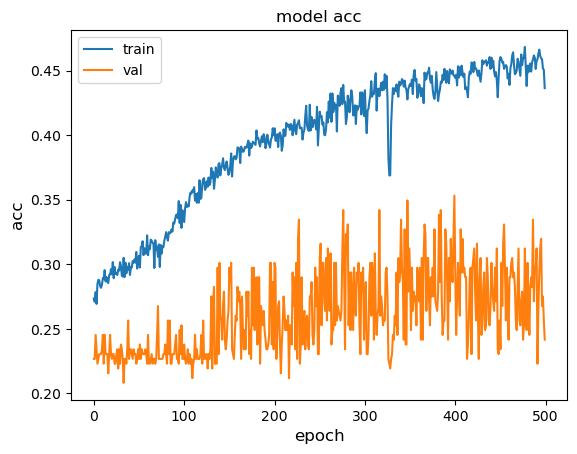

In [332]:
metric = "acc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [333]:
y_pred = model.predict(X_test)
print(y_pred)
y_pred = np.argmax(y_pred, axis = 1)
print("Accuracy:", np.mean(y_pred == np.argmax(y_test, axis=1)))

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 10s 244ms/step
[[1.9251913e-02 7.3348433e-01 2.4725924e-01 4.4966205e-06]
 [1.0000000e+00 3.9095337e-12 2.5419328e-14 2.9500054e-21]
 [1.0000000e+00 9.8116251e-14 5.8388924e-16 1.5839945e-22]
 ...
 [1.0000000e+00 9.4832535e-14 5.6515468e-16 1.5592584e-22]
 [1.0000000e+00 9.5986634e-14 5.7137608e-16 1.5376983e-22]
 [9.9865949e-01 1.2525792e-03 8.8036963e-05 1.1394172e-12]]
Accuracy: 0.2594553706505295
42/42 [==============================] - 10s 243ms/step - loss: 24.0676 - acc: 0.2595
Test accuracy 0.2594553828239441
Test loss 24.067569732666016
